In [1]:
import os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
#os.environ["CUDA_LAUNCH_BLOCKING"] = 1

import random
import numpy as np
import matplotlib.pyplot as plt

import json
import cv2
from tqdm import tqdm
from PIL import Image

PATH = "/home/faisal/7.1.e_optha_EX"
train_image_dir = os.path.join(PATH, "training/images")
train_ann_dir = os.path.join(PATH, "training/ground_truth/Hard Exudates")
val_image_dir = os.path.join(PATH, "validation/images")
val_ann_dir = os.path.join(PATH, "validation/ground_truth/Hard Exudates")
test_image_dir = os.path.join(PATH, "test/images")
test_ann_dir = os.path.join(PATH, "test/ground_truth/Hard Exudates")
train_image_names = sorted(os.listdir(train_image_dir))
train_ann_names = sorted(os.listdir(train_ann_dir))
val_image_names = sorted(os.listdir(val_image_dir))
val_ann_names = sorted(os.listdir(val_ann_dir))
test_image_names = sorted(os.listdir(test_image_dir))
test_ann_names = sorted(os.listdir(test_ann_dir))



import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF 
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class SEGDataset(Dataset):
    def __init__(self, image_dir, ann_dir, image_names_list, ann_names_list, transform = None):
        super(SEGDataset, self).__init__()
        self.image_dir = image_dir
        self.ann_dir = ann_dir
        self.images = image_names_list
        self.anns = ann_names_list
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        ann_path = os.path.join(self.ann_dir, self.anns[index])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)
        #mask = Image.open(ann_path)
        #mask = np.array(mask)
        mask[mask > 1] = 1
        mask[mask < 1] = 0
        '''ann_file = open(ann_path)
        ann_data = json.load(ann_file)
        #tile_example(img_path, mask_rle, ex_id, organ, 
        mask = np.zeros(shape = image.shape[:-1])
        for idx in range(len(ann_data)):
            ann = [np.array(ann_data[idx], dtype = np.int32)]
            cv2.fillPoly(mask, pts = ann, color = (255, 255, 255))'''
        
        # mask[mask >= 128.0] = 1
        # mask[mask < 128.0] = 0
        
        if self.transform is not None:
            transformer = self.transform(image = image, mask = mask)
            image, mask = transformer["image"], transformer["mask"]
            
        return image, mask
    
#Splitting into train and val sets
random.seed(53)
np.random.seed(53)
torch.manual_seed(53)
'''np.random.shuffle(image_names)
N = len(image_names)
train_len = int(0.9 * N)
val_len = N - train_len'''
#train_image_names = image_names[:train_len]
#val_image_names = image_names[train_len:]
#print(f"No. of training images = {train_len}")
#print(f"No. of validation images = {val_len}")

def get_dataloaders(img_size = 256, batch_size = 16, image_dir = None, ann_dir = None, train_image_dir = None, val_ann_dir = None, test_ann_dir = None,
                    train_image_names = None, train_ann_names = None, val_image_names = None, val_ann_names = None, test_image_names = None, test_ann_names = None):
    
    
    train_transforms = A.Compose([
        A.PadIfNeeded(min_height=4288, min_width=4288, p=1),
        A.Resize(height = img_size, width = img_size, always_apply =True),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.Rotate(limit = 90, p = 0.5),
        A.Normalize(
        mean = (0, 0, 0), std = (1.0, 1.0, 1.0), max_pixel_value = 255.0
        ),
        ToTensorV2()
    ])
    val_transforms = A.Compose([
        A.PadIfNeeded(min_height=4288, min_width=4288, border_mode=cv2.BORDER_CONSTANT, p=1),
        A.Resize(height = img_size, width = img_size, always_apply =True),
        A.Normalize(
        mean = (0, 0, 0), std = (1.0, 1.0, 1.0), max_pixel_value = 255.0
        ),
        ToTensorV2()
    ])
    test_transforms = A.Compose([
        A.PadIfNeeded(min_height=4288, min_width=4288, border_mode=cv2.BORDER_CONSTANT, p=1),
        A.Resize(height = img_size, width = img_size, always_apply =True),
        A.Normalize(
        mean = (0, 0, 0), std = (1.0, 1.0, 1.0), max_pixel_value = 255.0
        ),
        ToTensorV2()
    ])
    

    train_dataset = SEGDataset(image_dir, ann_dir, train_image_names, train_ann_names, train_transforms)
    val_dataset = SEGDataset(val_image_dir, val_ann_dir, val_image_names, val_ann_names, val_transforms)
    test_dataset = SEGDataset(test_image_dir, test_ann_dir, test_image_names, test_ann_names, test_transforms)

    g_seed = torch.Generator()
    g_seed.manual_seed(0)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True, num_workers = 8)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, pin_memory = True, num_workers = 8)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, pin_memory = True, num_workers = 8)
    
    return train_loader, val_loader, test_loader

/home/faisal/.conda/envs/faisal/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Little AUNet

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
#from focal_loss.focal_loss import FocalLoss
import torchvision
import sys
#from torchsummary import summary
from ptflops import get_model_complexity_info
from torchinfo import summary
from torchstat import stat


import matplotlib.pyplot as plt
import time
from torchvision import models

import torch
import torch.nn as nn
import torch.nn.functional as F


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, k_sz=3, shortcut=False, pool=True):
        '''
        pool_mode can be False (no pooling) or True ('maxpool')
        '''
        super(ConvBlock, self).__init__()
        if shortcut==True: self.shortcut = nn.Sequential(conv1x1(in_c, out_c), nn.BatchNorm2d(out_c))
        else: self.shortcut=False
        pad = (k_sz - 1) // 2

        block = []
        if pool: self.pool = nn.MaxPool2d(kernel_size=2)
        else: self.pool = False

        block.append(nn.Conv2d(in_c, out_c, kernel_size=k_sz, padding=pad))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_c))

        block.append(nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding=pad))
        block.append(nn.ReLU())
        block.append(nn.BatchNorm2d(out_c))

        self.block = nn.Sequential(*block)
    def forward(self, x):
        if self.pool: x = self.pool(x)
        out = self.block(x)
        if self.shortcut: return out + self.shortcut(x)
        else: return out
        
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, dilation = [1,2,3]):
        super(ResBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_c)
        #self.relu = nn.ReLU(inplace=True)
        self.mish = nn.GELU()
        self.conv1 = nn.Conv2d(in_c, out_c // 4 , 1)
        self.bn2 = nn.BatchNorm2d(out_c // 4)
        #self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c // 4, out_c // 4, 3, padding='same')
        # self.conv3 = nn.Conv2d(out_c * 4, out_c, 3, padding='same', dilation=dilation[1])
        # self.conv4 = nn.Conv2d(out_c * 4, out_c, 3, padding='same', dilation=dilation[2])
        
        
        #self.conv2 = nn.Conv2d(output_channels/4, output_channels/4, 3, stride, padding = 1, bias = False)
        self.dropout = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm2d(out_c // 4)
        #self.relu = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(out_c // 4, out_c, 1, 1, bias = False)
        self.conv6 = nn.Conv2d(in_c, out_c , 1, 1, padding='same', bias = False)
        
    def forward(self, x):
        #residual = x
        #out = self.bn1(x)
        #out = self.mish(out)
        out = self.conv1(x)
        #out = self.bn2(out)
        out = self.mish(out)
        out = self.conv2(out)
        # out2 = self.conv3(out)
        # out3 = self.conv4(out)
        # out = torch.add(torch.add(out1,out2),out3)
        #out =  self.conv2(out)+ self.conv3(out)+ self.conv4(out)
        out = self.bn3(out)
        out = self.dropout(out)
        out = self.mish(out)
        out = self.conv5(out)
        
       
        #if (self.input_channels != self.output_channels) or (self.stride !=1 ):
        residual = self.conv6(x)
        out += residual
        return out


class AttConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, k_sz=3, shortcut=False, pool=True, attention=False):
        '''
        pool_mode can be False (no pooling) or True ('maxpool')
        '''
        super(AttConvBlock, self).__init__()
        if shortcut==True: self.shortcut = nn.Sequential(conv1x1(in_c, out_c), nn.BatchNorm2d(out_c))
        else: self.shortcut=False
        pad = (k_sz - 1) // 2

        if pool: self.pool = nn.MaxPool2d(kernel_size=2)
        else: self.pool = False

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=k_sz, padding=pad),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding=pad),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )
        if attention==True:
            self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

            #self.softmax1_blocks = DiResBlock(in_c, out_c, dilation= [1,2,4])
            self.softmax1_blocks = nn.Conv2d(in_c, out_c, kernel_size=k_sz, padding='same', dilation= 2)

            self.skip1_connection_residual_block = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same')

            self.mpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

            #self.softmax2_blocks = DiResBlock(out_c, out_c, dilation= [2,4,8])
            self.softmax2_blocks = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same', dilation= 4)

            self.skip2_connection_residual_block = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same')

            self.mpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.softmax3_blocks = nn.Sequential(
                nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same', dilation= 8),
                nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same', dilation= 8)
            )

            self.interpolation3 = nn.UpsamplingBilinear2d(scale_factor=2)

            #self.softmax4_blocks = DiResBlock(out_c, out_c, dilation= [2,4,8])
            self.softmax4_blocks = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same', dilation= 4)

            self.interpolation2 = nn.UpsamplingBilinear2d(scale_factor=2)

            #self.softmax5_blocks = DiResBlock(out_c, out_c, dilation= [1,2,4])
            self.softmax5_blocks = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same', dilation= 2)

            self.interpolation1 = nn.UpsamplingBilinear2d(scale_factor=2)

            self.softmax6_blocks = nn.Sequential(
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c , kernel_size = 1, stride = 1, bias = False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c , kernel_size = 1, stride = 1, bias = False),
                nn.Sigmoid()
            )

            self.last_blocks = nn.Conv2d(out_c, out_c, kernel_size=k_sz, padding='same')
        
    def forward(self, x, attention = False):
        if self.pool: x = self.pool(x)
        out_trunk = self.conv(x)
        if attention==True:
            out_mpool1 = self.mpool1(x)
            out_softmax1 = self.softmax1_blocks(out_mpool1)
            out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
            out_mpool2 = self.mpool2(out_softmax1)
            out_softmax2 = self.softmax2_blocks(out_mpool2)
            #print(out_softmax2.data.shape)
            out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
            out_mpool3 = self.mpool3(out_softmax2)
            out_softmax3 = self.softmax3_blocks(out_mpool3)
            #
            out_interp3 = self.interpolation3(out_softmax3)
            #print(out_skip2_connection.data.shape)
            #print(out_interp3.data.shape)
            out = torch.add(out_interp3, out_skip2_connection)
            out_softmax4 = self.softmax4_blocks(out)
            out_interp2 = self.interpolation2(out_softmax4)
            out = torch.add(out_interp2, out_skip1_connection)
            out_softmax5 = self.softmax5_blocks(out)
            out_interp1 = self.interpolation1(out_softmax5)
            out_softmax6 = self.softmax6_blocks(out_interp1)
            #print(out_softmax6.shape)
            #print(out_trunk.shape)
            out = torch.multiply((1 + out_softmax6), out_trunk)
            out = self.last_blocks(out)
        else:
            out = out_trunk
        if self.shortcut: return out + self.shortcut(x)
        else: return out
        
        
class UpsampleBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, up_mode='transp_conv'):
        super(UpsampleBlock, self).__init__()
        block = []
        if up_mode == 'transp_conv':
            block.append(nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2))
        elif up_mode == 'up_conv':
            block.append(nn.UpsamplingBilinear2d(scale_factor=2))
            block.append(nn.Conv2d(in_c, out_c, kernel_size=1))
        else:
            raise Exception('Upsampling mode not supported')

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out
    
class DoubleAttBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, k_sz=3, shortcut= True, attention = True):
        super(DoubleAttBlock, self).__init__()
        

        self.block1 = AttConvBlock(in_c, in_c, k_sz=k_sz,
                              shortcut=shortcut, pool=False, attention=False)
        self.block2 = AttConvBlock(in_c, out_c, k_sz=k_sz,
                              shortcut=shortcut, pool=True, attention=attention)

    def forward(self, x):
        out = self.block1(x, attention = False)
        out = self.block2(out, attention = True)
        return out

class ConvBridgeBlock(torch.nn.Module):
    def __init__(self, channels, k_sz=3):
        super(ConvBridgeBlock, self).__init__()
        # pad = (k_sz - 1) // 2
        # block=[]

        # block.append(nn.Conv2d(channels, channels, kernel_size=k_sz, padding=pad))
        # block.append(nn.ReLU())
        # block.append(nn.BatchNorm2d(channels))

        # self.block = nn.Sequential(*block)
        self.block = ResBlock(channels, channels)

    def forward(self, x):
        out = self.block(x)
        return out

class UpConvBlock(torch.nn.Module):
    def __init__(self, in_c, out_c, k_sz=3, up_mode='up_conv', conv_bridge=False, shortcut=False):
        super(UpConvBlock, self).__init__()
        self.conv_bridge = conv_bridge

        self.up_layer = UpsampleBlock(in_c, out_c, up_mode=up_mode)
        self.conv_layer1 = AttConvBlock(out_c, out_c, k_sz=k_sz, shortcut=shortcut, pool=False, attention= True)
        self.conv_layer2 = AttConvBlock(2 * out_c, out_c, k_sz=k_sz, shortcut=shortcut, pool=False, attention= True)
        if self.conv_bridge:
            self.conv_bridge_layer = ConvBridgeBlock(out_c, k_sz=k_sz)

    def forward(self, x, skip):
        up = self.up_layer(x)
        up = self.conv_layer1(up, attention = True)
        #skip = torch.multiply((1 + up), skip)
        if self.conv_bridge:
            skip = self.conv_bridge_layer(skip)
            skip = torch.multiply((1 + up), skip)
            out = torch.cat([up, skip], dim=1) 
        else:
            skip = torch.multiply((1 + up), skip)
            out = torch.cat([up, skip], dim=1)
        out = self.conv_layer2(out, attention = True)
        return out

class UNet(nn.Module):
    def __init__(self, in_c, n_classes, layers, k_sz=3, up_mode='up_conv', conv_bridge=True, shortcut=True):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.first = ConvBlock(in_c=in_c, out_c=layers[0], k_sz=k_sz,
                               shortcut=shortcut, pool=False)

        self.down_path = nn.ModuleList()
        for i in range(len(layers) - 1):
            block = DoubleAttBlock(in_c=layers[i], out_c=layers[i + 1], k_sz=k_sz,
                              shortcut=shortcut, attention=True)
            self.down_path.append(block)

        self.up_path = nn.ModuleList()
        reversed_layers = list(reversed(layers))
        for i in range(len(layers) - 1):
            block = UpConvBlock(in_c=reversed_layers[i], out_c=reversed_layers[i + 1], k_sz=k_sz,
                                up_mode=up_mode, conv_bridge=conv_bridge, shortcut=shortcut)
            self.up_path.append(block)

        # init, shamelessly lifted from torchvision/models/resnet.py
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        self.final = nn.Conv2d(layers[0], n_classes, kernel_size=1)

    def forward(self, x):
        x = self.first(x)
        down_activations = []
        for i, down in enumerate(self.down_path):
            down_activations.append(x)
            x = down(x)
        down_activations.reverse()
        for i, up in enumerate(self.up_path):
            x = up(x, down_activations[i])
        return self.final(x)

In [3]:
def validate(model, loader, epoch, device = 'cpu'):
    model.eval()
    loss_ep = 0
    dice_coeff_ep = 0.0
    jaccard_indx = 0
    f1_ep = 0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)
            #outputs = F.sigmoid(model(images))
            #criterion = FocalLoss(gamma= 2, alpha = alpha)
            loss = criterion(outputs, masks)
            #loss = criterion(outputs, masks.unsqueeze(1).float())
            _, pred = outputs.max(1)
            #num_correct += (pred == masks).sum()
            #num_samples += pred.size(0)
            #dice_coeff_ep += dice_coeff_binary(pred.detach(), masks.to(device).unsqueeze(1))
            dice_coeff_ep += dice(pred.detach(), masks.to(device).unsqueeze(1), average = 'weighted', num_classes = 2)
            jaccard_indx += ji(pred.detach(), masks.to(device), 'multiclass', num_classes = 2)
            f1_ep += f1_score(pred.detach(), masks.to(device), 'multiclass', average = 'macro', multidim_average= 'global', num_classes = 2)
            loss_ep += loss.item()
    val_loss = loss_ep/len(loader)
    dice_coeff = dice_coeff_ep/len(loader)
    jac_indx = jaccard_indx/len(loader)
    f1 = f1_ep/len(loader)
    return val_loss, dice_coeff, jac_indx , f1

In [4]:
from torchmetrics.functional import jaccard_index as ji
from torchmetrics.functional import dice
from torchmetrics.functional import f1_score

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
img_size = 1024
batch_size = 8

train_loader, val_loader, test_loader = get_dataloaders(img_size, batch_size, train_image_dir, train_ann_dir, val_image_dir, val_ann_dir, test_ann_dir, train_image_names, train_ann_names, val_image_names, val_ann_names, test_image_names, test_ann_names)

#model = MeDiAUNET(in_channels = 3, out_channels = 2 ,features = [64, 128, 256, 512])
#model = MeDiAUNET(in_channels = 3, out_channels = 2)
#model = SUMNet_all_bn(in_ch=3,out_ch=2)

In [5]:
#model = MeDiAUNET(in_channels = 3, out_channels = 2 ,features = [64, 128, 256, 512])
#model = MeDiAUNET(in_channels = 3, out_channels = 2)
#model = SUMNet_all_bn(in_ch=3,out_ch=2)
model = UNet(in_c=3, n_classes=2, layers=[8,16,32,64], conv_bridge=True, shortcut=True)

model.to(device)
#checkpoint_dir = "/home/dipayan/Anupam/IDRiD/Little_AUNet/weights"
#checkpoint_dir = "/home/dipayan/Anupam/IDRiD/SUMNet/weights"
checkpoint_dir = "/home/faisal/Little AUNet/7.1.e_optha_EX/Hard Exudates/weights"
#checkpoint_dir = "/home/dipayan/Anupam/IDRiD/UNext/weights"
#checkpoint_dir = "/home/dipayan/Anupam/IDRiD/ResUNet++/weights"
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_weight.tar"), map_location = torch.device('cpu'))["model_state_dict"])
#model.to('cuda')
model.eval()


UNet(
  (first): ConvBlock(
    (shortcut): Sequential(
      (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down_path): ModuleList(
    (0): DoubleAttBlock(
      (block1): AttConvBlock(
        (shortcut): Sequential(
          (0): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (conv): Sequential(
          (0): Conv2d(8, 8, kernel_size=(3, 3), stride=

In [6]:
from ptflops import get_model_complexity_info
from torchinfo import summary
from torchstat import stat
def test_model():
    mod = UNet(in_c=3, n_classes=2, layers=[8,16,32], conv_bridge=True, shortcut=True)
    #x = torch.randn((1, 3, 512, 512))
    #mod.cuda()
    #pred = mod(x)
    #print(stat(mod, input_size=(3, 512, 512)))
    #print(summary(mod, input_size=(1, 3, 1024, 1024)))
    macs, params = get_model_complexity_info(mod, (3, 1024, 1024),
                                             as_strings=True,
                                             print_per_layer_stat=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    
    #print(pred.shape)

test_model()

Computational complexity:       21.25 GMac
Number of parameters:           200.35 k


100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


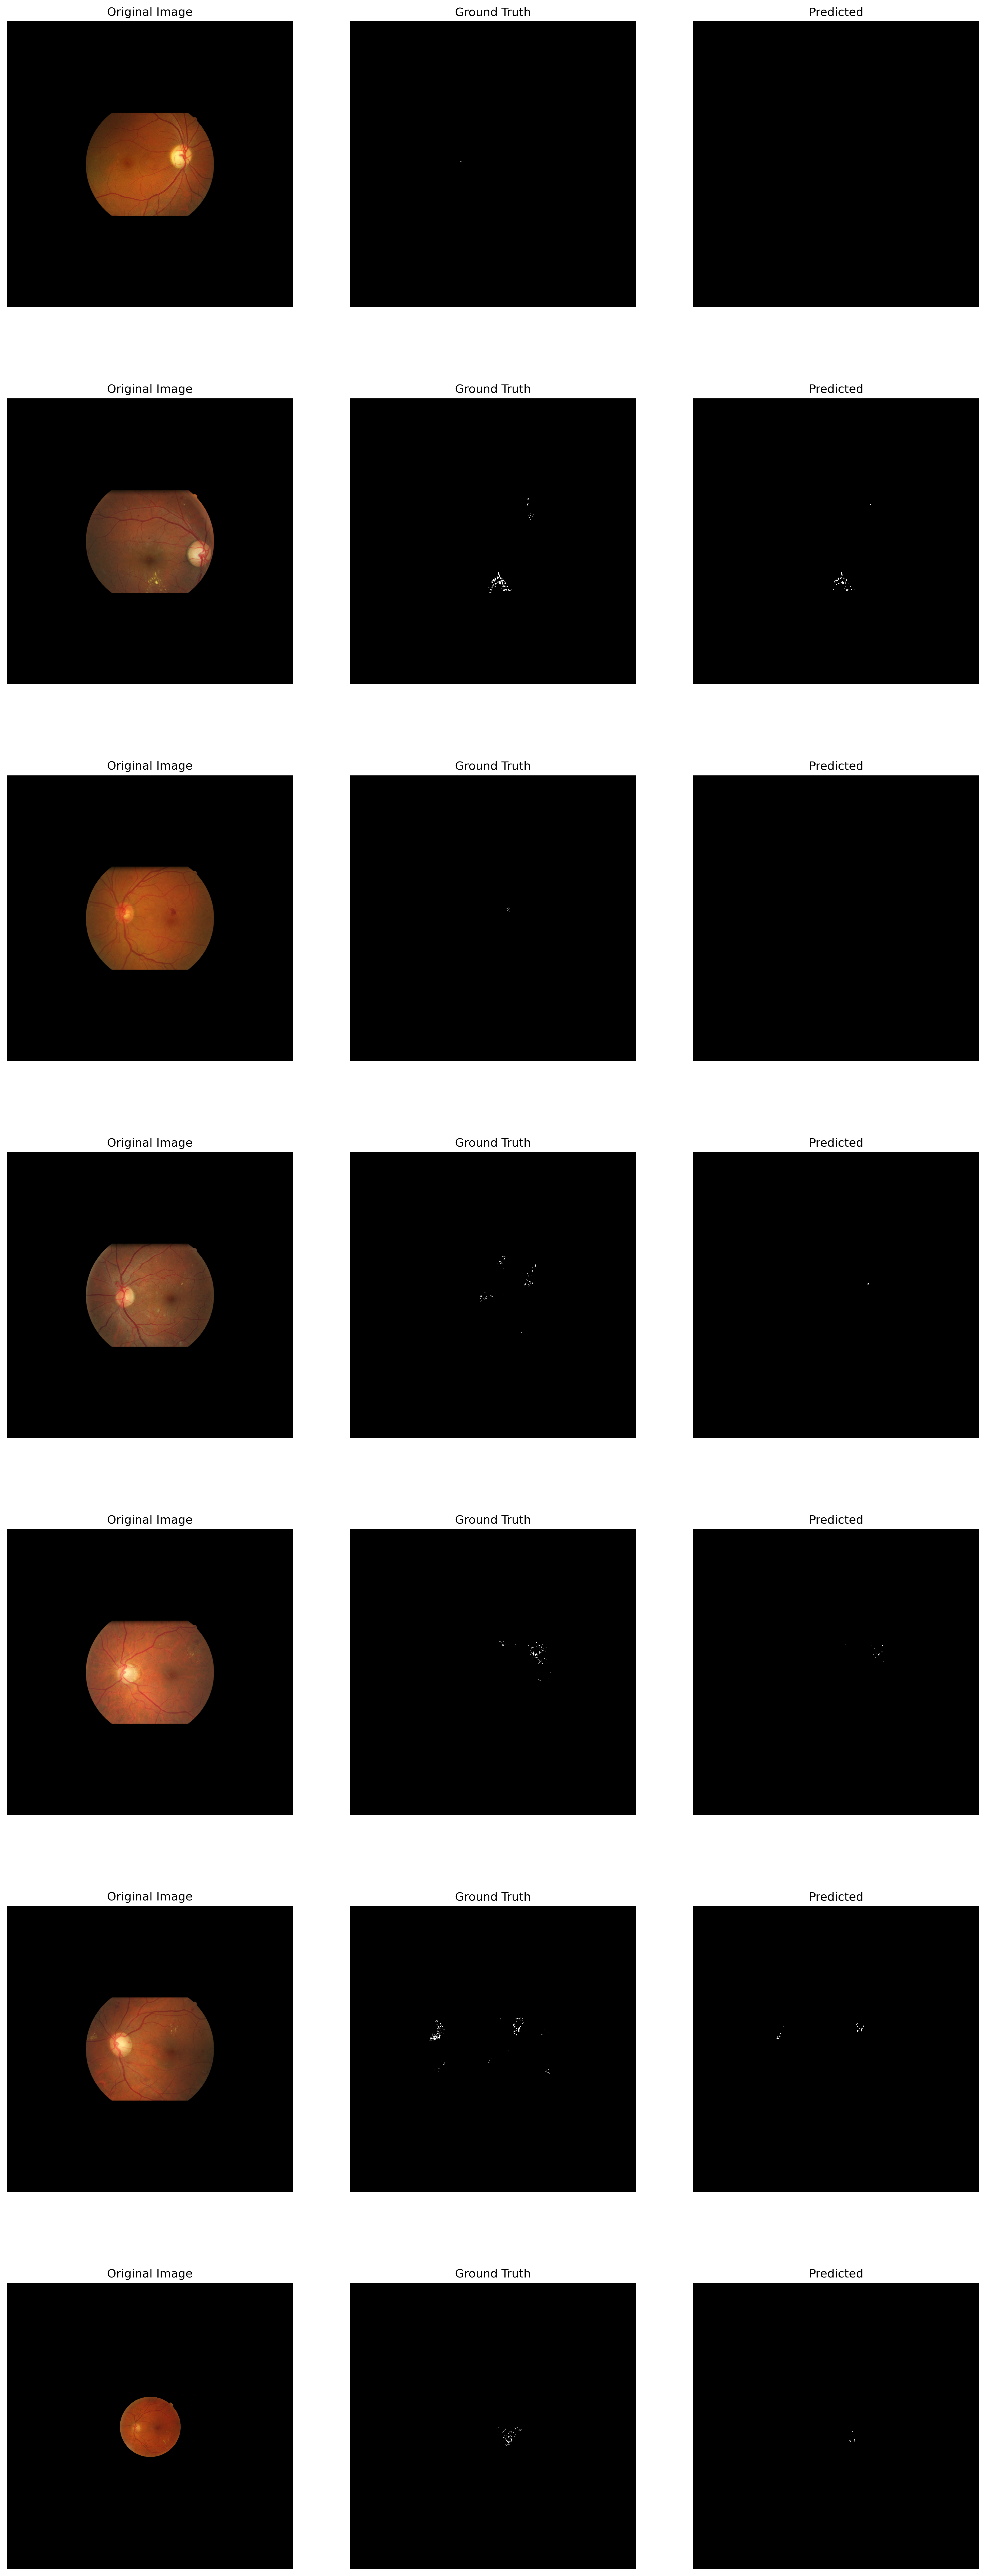

In [7]:

fig, ax = plt.subplots(nrows = 7, ncols = 3, figsize = (18, 8*6), dpi = 300)
imgs, masks = next(iter(test_loader))
for i in tqdm(range(7)):
    dice_coeff_ep = 0
    jaccard_indx =0
    f1_ep = 0
    img = imgs[i]
    mask = masks[i].numpy()
    mask[mask == 1] == 255
    with torch.no_grad():
        output = model(img.unsqueeze(0))
        _, pred_mask = output.max(1)
        pred_mask = pred_mask.squeeze(0).numpy()
        pred_mask[pred_mask == 1] = 255
        # images = imgs[i].to(device)
        # masks = masks[i].to(device).long()
        # outputs = model(images.unsqueeze(0))
        # _, pred = outputs.max(1)

        # dice_coeff_ep = dice(pred.detach(), masks.to(device).unsqueeze(1), average = 'weighted', num_classes = 2)
        # jaccard_indx = ji(pred.detach(), masks.to(device).unsqueeze(1), 2)
        # f1_ep = f1_score(pred.detach(), masks.to(device).unsqueeze(1), average = 'macro', mdmc_average= 'global', num_classes = 2)
        # else:
        #     dice_coeff_ep = dice(pred.detach().float(), masks.to(device).unsqueeze(1))
        #     jaccard_indx = ji(pred.detach().float(), masks.to(device).unsqueeze(1), 2)
        #     f1_ep = f1_score(pred.detach().float(), masks.to(device).unsqueeze(1), average = 'macro', mdmc_average= 'global', num_classes = 2)
    img = img.permute(1,2,0).numpy()
    ax[i,0].imshow(img)
    ax[i,0].set_title('Original Image')
    ax[i,0].axis('off')
    ax[i,1].set_title('Ground Truth')
    ax[i,1].imshow(mask, cmap = 'gray')
    ax[i,1].axis('off')
    ax[i,2].set_title('Predicted')#, dice coeff={dice_coeff_ep}, Jac Index={jaccard_indx}, F1 Score={f1_ep}'.format(dice_coeff_ep=dice_coeff_ep,jaccard_indx=jaccard_indx,f1_ep=f1_ep), fontsize = 10)
    ax[i,2].imshow(pred_mask, cmap = 'gray')
    ax[i,2].axis('off')
plt.savefig('/home/faisal/Little AUNet/7.1.e_optha_EX/Hard Exudates/Little_AUNet_pred_Hard Exudates.png')
plt.show()

In [8]:
criterion = nn.CrossEntropyLoss()
validate(model, test_loader, epoch=1)

(0.001350540667772293, tensor(0.9996), tensor(0.6021), tensor(0.6697))

In [9]:
criterion = nn.CrossEntropyLoss()
validate(model, val_loader, epoch=1)

(0.0035809071268886328, tensor(0.9991), tensor(0.5593), tensor(0.6064))